In [2]:
import pandas as pd
# from crim_intervals.funcs import *
from intervals.main_objs import *
from intervals.main import *

from ipywidgets import interact
import re

music21: Certain music21 functions might need the optional package matplotlib;
                  if you run into errors, install it by following the instructions at
                  http://mit.edu/music21/doc/installing/installAdditional.html


In [3]:
def map_colours(x, rest_colour="#fbb4ae", empty_colour="white", remainder_colour="#ccebc5"):
    if x == "Rest":
        return f"background: {rest_colour}"
    elif pd.isnull(x) or (not x) or (x == "-"):
        return f"background: {empty_colour}"
    else:
        return f"background: {remainder_colour}"
    
    
def add_offset(s, lyric_line=3):
    for n in s.recurse().getElementsByClass('Note'):
        n.addLyric(int(n.getOffsetBySite(s.flat.notes)), lyric_line)

# Select Piece

In [30]:
piece = 'https://crimproject.org/mei/CRIM_Mass_0002_1.mei'
corpus = CorpusBase([piece])

Requesting file from https://crimproject.org/mei/CRIM_Mass_0002_1.mei...
Successfully imported.


In [33]:
model = corpus.scores[0]

In [34]:
model.score.metadata.title

'Missa Vidi speciosam - Kyrie'

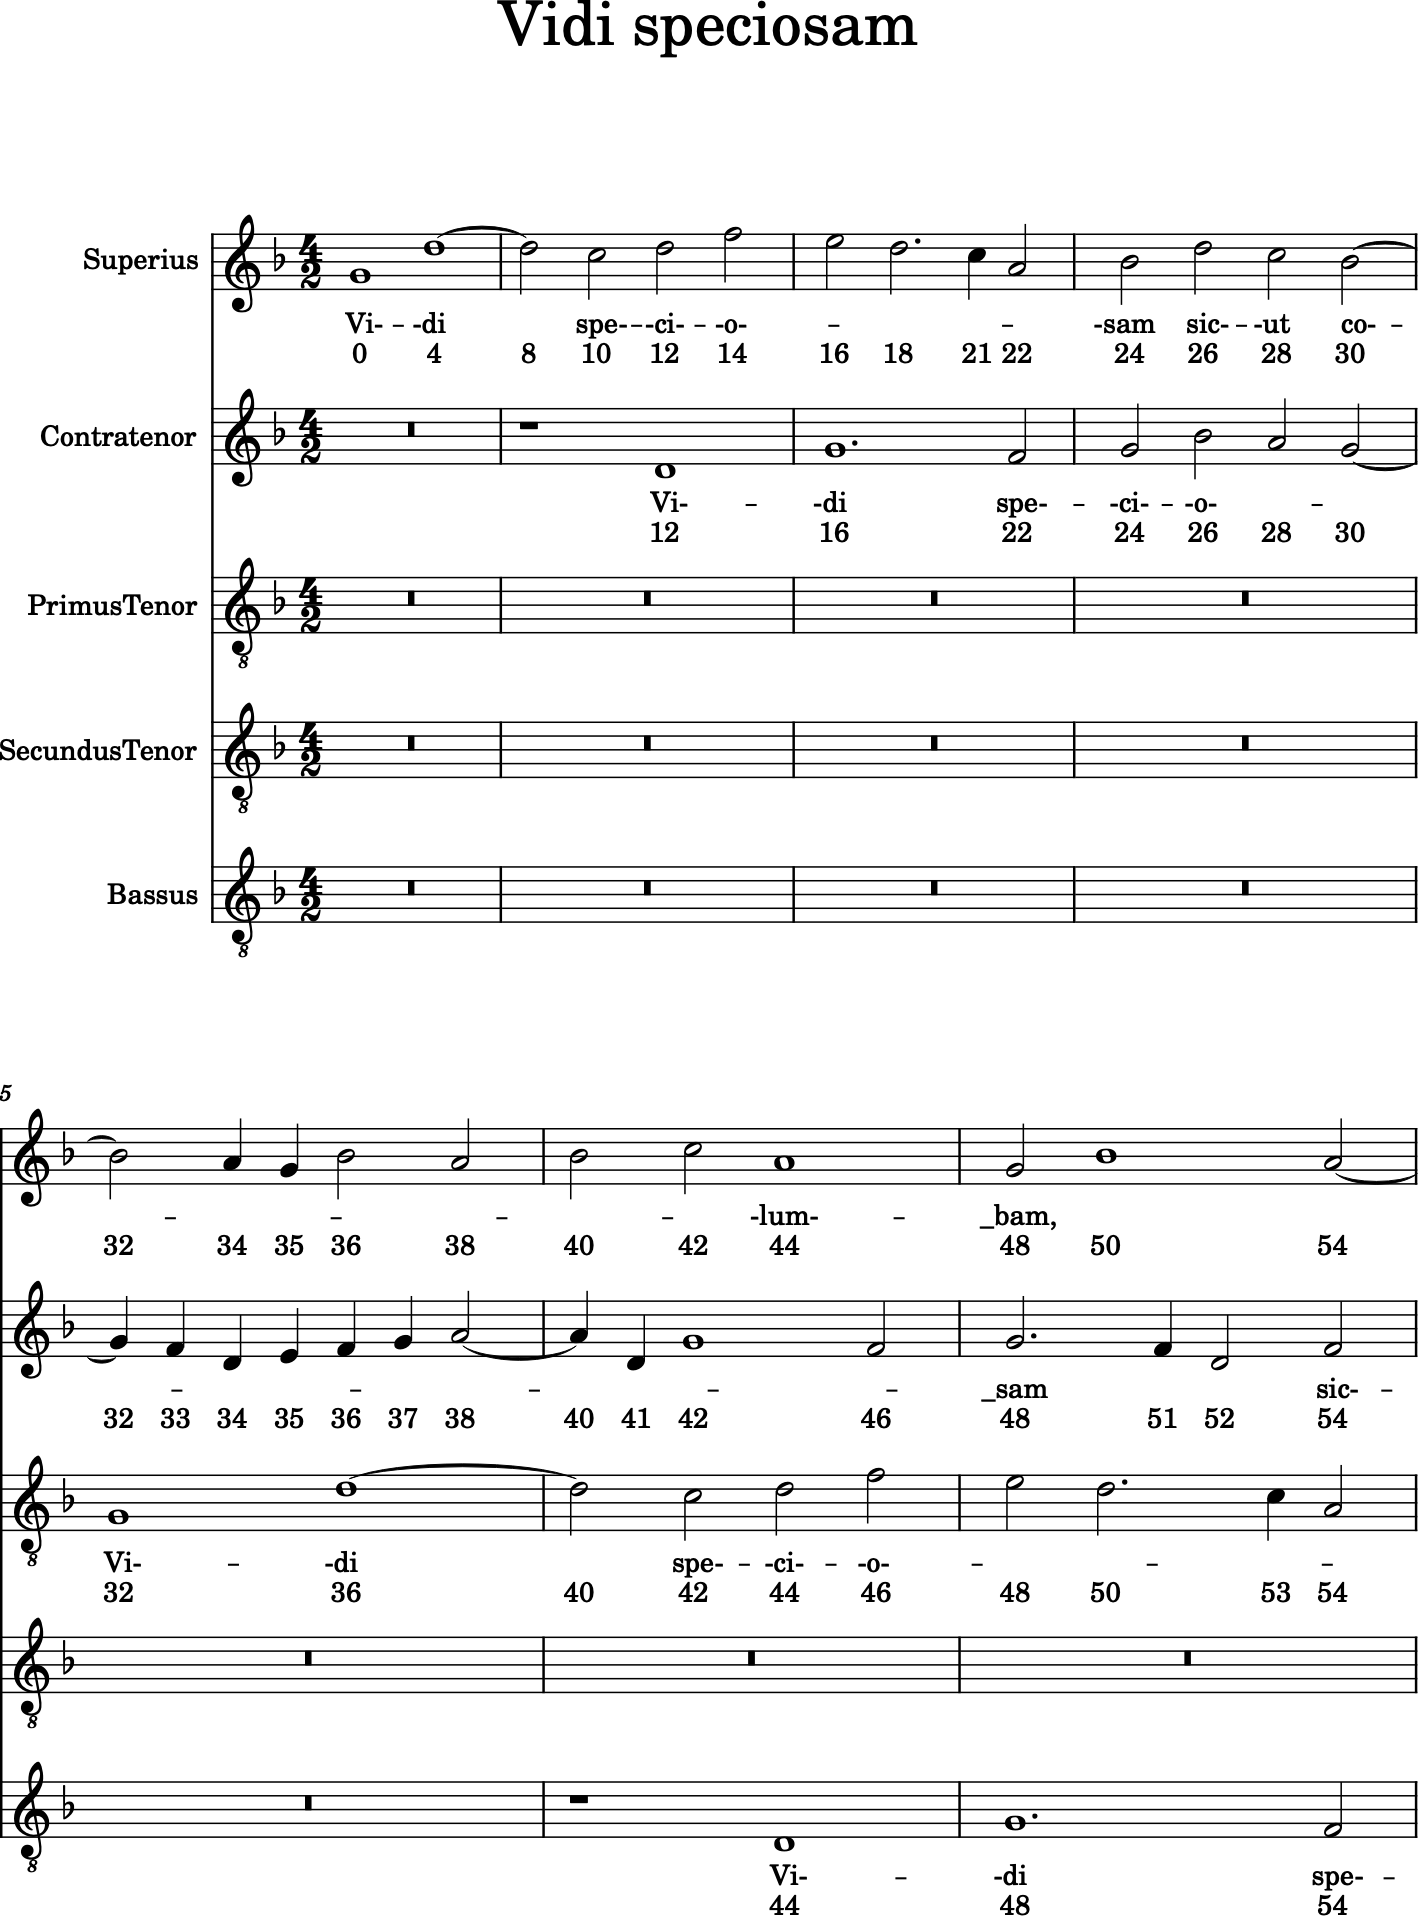

In [12]:
add_offset(model.score)
model.score.measures(1, 15).show()

# Music as a table

In [13]:
model.getNoteRest().head(10).fillna("-").T.style.applymap(map_colours)

,0.0,4.0,8.0,10.0,12.0,14.0,16.0,18.0,21.0,22.0
Superius,G4,D5,-,C5,D5,F5,E5,D5,C5,A4
Contratenor,Rest,-,Rest,-,D4,-,G4,-,-,F4
PrimusTenor,Rest,-,Rest,-,-,-,Rest,-,-,-
SecundusTenor,Rest,-,Rest,-,-,-,Rest,-,-,-
Bassus,Rest,-,Rest,-,-,-,Rest,-,-,-


# Melodic patterns

In [14]:
model_melodic = model.getMelodic(kind="d", unit=2)
# ave_melodic

In [15]:
ngrams = model.getNgrams(df=model.getMelodic(kind="d", compound=True), n=5)
ngrams

,Superius,Contratenor,PrimusTenor,SecundusTenor,Bassus
4.0,"5, -2, 2, 3, -2",NaN,NaN,NaN,NaN
10.0,"-2, 2, 3, -2, -2",NaN,NaN,NaN,NaN
12.0,"2, 3, -2, -2, -2",NaN,NaN,NaN,NaN
14.0,"3, -2, -2, -2, -3",NaN,NaN,NaN,NaN
16.0,"-2, -2, -2, -3, 2","4, -2, 2, 3, -2",NaN,NaN,NaN
...,...,...,...,...,...
1058.0,NaN,"-2, 2, -2, -2, -2",NaN,"-2, 2, 3, -2, -2",NaN
1060.0,NaN,"2, -2, -2, -2, 4",NaN,"2, 3, -2, -2, -2","-5, 2, 2, 2, 2"
1063.0,NaN,"-2, -2, -2, 4, -2",NaN,NaN,"2, 2, 2, 2, -3"
1064.0,NaN,NaN,NaN,NaN,"2, 2, 2, -3, -3"


## Searching with various parameters
* Note that if 'units' are no specified, then the results are simply the melodic vectors, regardless of duration.
* If we specify "units" then the results are incremental by that unit
* The results will be different in each case
* Sample search: 4, 1, 2, 2 or chromatic 5, 0, 2, 2, -4

In [16]:
# Ngrams without time_units
@interact(search_pattern="", kind=["d", "c"])
def get_ngrams(search_pattern, kind):
    ngrams = model.getNgrams(df=model.getMelodic(kind=kind), n=5)
    mask = ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)
    filtered_ngrams = ngrams[mask].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

In [17]:
# NGrams with time_units

@interact(search_pattern="", kind=["d", "c"], time_unit=[1, 2, 4, 8], length=[3, 4, 5, 6, 7])
def get_ngrams(search_pattern, kind, time_unit, length):
    ngrams = model.getNgrams(df=model.getMelodic(kind=kind), n=length, unit=time_unit)
    mask = ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)
    filtered_ngrams = ngrams[mask].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

# Count of melodic intervals

In [18]:
model.getMelodic(directed=True).apply(pd.Series.value_counts).fillna(0).astype(int).style.bar()

,Superius,Contratenor,PrimusTenor,SecundusTenor,Bassus
-M2,105,114,90,84,72
-M3,10,10,10,12,16
-P4,2,4,4,2,2
-P5,2,6,4,6,10
-P8,0,0,0,1,0
-m2,49,46,34,31,26
-m3,17,22,25,25,23
A4,0,3,0,0,0
M2,74,101,75,85,69
M3,4,2,3,2,0


# Harmonic intervals

Example search pattern: 12, 10, 8, 8|5, 3, 1, 1$

Authentic cadence:  7, 6, 8

In [21]:
# note that time_unit does not yet work with getHarmonic
@interact(search_pattern="", compound=[True, False], kind=["d", "c"], time_unit=[1, 2, 4, 8], length=[3, 4, 5, 6, 7])
def get_harmonic_ngrams(search_pattern, compound, kind, time_unit, length):    
    model_harmonic = model.getHarmonic(kind=kind, compound=compound)
    ngrams = model.getNgrams(df=model_harmonic, n=length, cell_type="str", unit=time_unit)
    filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if re.match(search_pattern, x) else "")


interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='compound', options=(…

In [24]:
har = model.getHarmonic(kind="d")
regHar = model.regularize(df=har, unit=1)
regHar

,Bassus_SecundusTenor,Bassus_PrimusTenor,Bassus_Contratenor,Bassus_Superius,SecundusTenor_PrimusTenor,SecundusTenor_Contratenor,SecundusTenor_Superius,PrimusTenor_Contratenor,PrimusTenor_Superius,Contratenor_Superius
0.0,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest
1.0,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest
2.0,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest
3.0,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest
4.0,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest,Rest
...,...,...,...,...,...,...,...,...,...,...
1083.0,3,1,5,8,-3,3,6,5,8,4
1084.0,3,1,5,8,-3,3,6,5,8,4
1085.0,3,1,5,8,-3,3,6,5,8,4
1086.0,3,1,5,8,-3,3,6,5,8,4


In [25]:
mel = model.getNgrams(df=model.getMelodic(kind="d"), n=4)
# regMel = ave_maria.regularize(df=mel, unit=4)
# regMel.stack().to_frame().reset_index(level=1)
b = mel.stack().to_frame().reset_index(level=1)
b.groupby("level_1")

## Return offsets as list
### For use with filtered DFs from classifier, etc.

In [35]:
df = get_harmonic_ngrams("7, 6, 8", True, "d", 1, 3)
a = df.index.tolist()
a
for i in a:
    b = i/8 - 1
    print(b)

8.0
9.0
22.0
25.5
26.375
29.375
33.5
38.0
39.5
40.0
49.0
53.625
60.5
63.0
67.375
82.375
83.0
88.1875
98.375
100.5
104.0
108.375
113.75
115.5
119.25
120.5
124.5
128.5
130.375


# Modules:

* Authentic/Phrygian cadence with suspension in diatonic:  7_Held, 6_-2, 8
* Authentic/Phrygian cadence with suspension in chromatic: 11_Held, 9_-2, 12
* Authentic/Phrygian cadence with suspension in zero-based:  6_Held, 5_-2, 7



In [27]:
@interact(search_pattern="", compound=[True, False], time_unit=[4, 2, 1, 8], length=[3, 4, 5, 6])
def get_modules(search_pattern, compound, time_unit, length):
    
    model_har = model.getHarmonic(kind="d", compound=compound)
    ngrams = model.getNgrams(df=model_har, n=length, how='modules', exclude=['Rest'], cell_type="str", unit=time_unit)
    filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if re.match(search_pattern, x) else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='compound', options=(…

In [35]:
model_har = model.getHarmonic(kind="d", compound=True)
ngrams = model.getNgrams(df=model_har, n=3, how='modules', exclude=['Rest'], cell_type="str")
# filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains('7').any(), axis=1)].copy()
# filtered_ngrams.stack().value_counts().to_frame()
ngrams.stack().value_counts().to_frame()

,0
"3_Held, 2_Held, 3",8
"6_-2, 7_-2, 8",8
"4_Held, 3_Held, 2",7
"5_-2, 6_-2, 7",7
"5_Held, 4_Held, 3",7
...,...
"5_2, 6_3, 3",1
"8_2, 6_2, 5",1
"-2_Held, -3_Held, 1",1
"6_Held, 5_2, 3",1


In [32]:
ave_maria.score.measures(1, 4).show()

NameError: name 'ave_maria' is not defined